# Ï†ÑÏù¥ ÌïôÏäµ - ÌäπÏÑ± Ï∂îÏ∂ú Í∏∞Î≤ï

In [ ]:
# ÎùºÏù¥Î∏åÎü¨Î¶¨ Ìò∏Ï∂ú

import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision # Ïª¥Ìì®ÌÑ∞ ÎπÑÏ†Ñ Ïö©ÎèÑÏùò Ìå®ÌÇ§ÏßÄ
import torchvision.transforms as transforms # Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨Î•º ÏúÑÌï¥ ÏÇ¨Ïö©ÎêòÎäî Ìå®ÌÇ§ÏßÄ
import torchvision.models as models # Îã§ÏñëÌïú ÌååÏù¥ÌÜ†Ïπò ÎÑ§Ìä∏ÏõåÌÅ¨Î•º ÏÇ¨Ïö©Ìï† Ïàò ÏûàÎèÑÎ°ù ÎèÑÏôÄÏ£ºÎäî Ìå®ÌÇ§ÏßÄ
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Train

In [ ]:
# Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞©Î≤ï Ï†ïÏùò

data_path = '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/train'

transform = transforms.Compose( # Ïó¨Îü¨ Í∞úÏùò Î≥ÄÌôòÏùÑ ÏàúÏ∞®Ï†ÅÏúºÎ°ú Ï†ÅÏö©
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224), # ÎûúÎç§ÌïòÍ≤å CropÌïú ÌõÑÏóê Ï£ºÏñ¥ÏßÑ ÌÅ¨Í∏∞ÎßåÌÅº Resize
        transforms.RandomHorizontalFlip(), # Default 0.5Ïùò ÌôïÎ•†Î°ú Ï¢åÏö∞Î∞òÏ†Ñ
        transforms.ToTensor()
    ]
)

# datasets.ImageFolder : Îç∞Ïù¥ÌÑ∞Î°úÎçîÍ∞Ä Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨Ïò¨ ÎåÄÏÉÅÍ≥º Î∞©Î≤ïÏùÑ Ï†ïÏùòÌï®
train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
# DataLoader : Ïù¥ÎØ∏ÏßÄÎ•º Î∂àÎü¨Ïò§Îäî Î∂ÄÎ∂Ñ (num_workers : ÌïòÏúÑ ÌîÑÎ°úÏÑ∏Ïä§Î•º Î™á Í∞ú ÏÇ¨Ïö©Ìï† Í≤ÉÏù∏ÏßÄ)
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)

print(len(train_dataset))

385


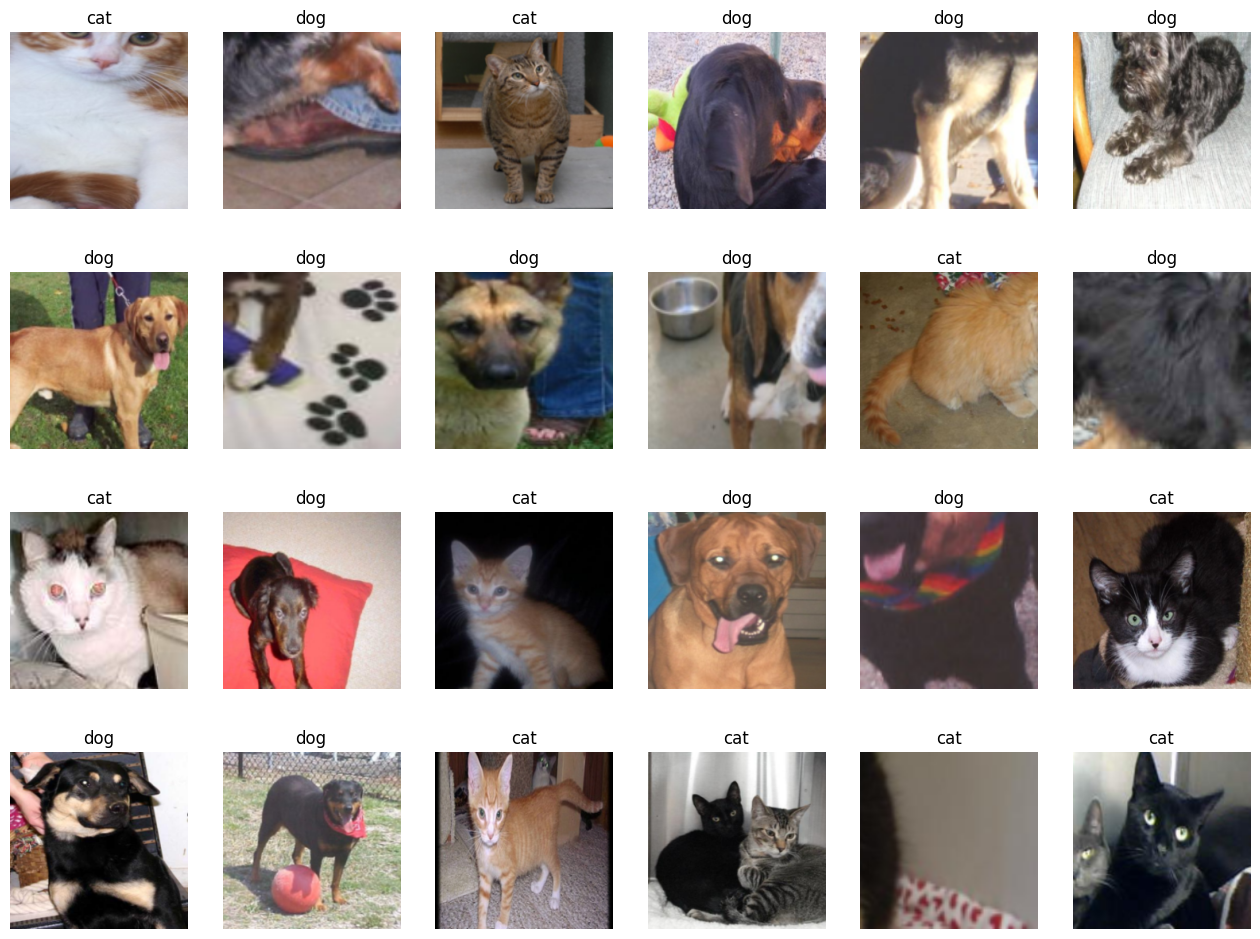

In [ ]:
# ÌïôÏäµÏóê ÏÇ¨Ïö©Îê† Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•

samples, labels = next(iter(train_loader)) # iter()Î°ú Î∞òÎ≥µÏûêÎ•º Íµ¨ÌïòÍ≥†, Í∑∏ Î∞òÎ≥µÏûêÎ•º next()Ïóê Ï†ÑÎã¨ÌïòÎ©∞ Ï∞®Î°ÄÎåÄÎ°ú Í∫ºÎÉÑ -> train_loaderÏïàÏóêÏÑú ÏÉòÌîå Ïù¥ÎØ∏ÏßÄÏôÄ Î†àÏù¥Î∏îÏùÑ ÏàúÏ∞®Ï†ÅÏúºÎ°ú Í∫ºÎÇ¥ Ï†ÄÏû•
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()]) # class[0] = 'cat' ÎòêÎäî class[1] = 'dog'
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0))) # ÌÖêÏÑúÎ•º ÎÑòÌååÏù¥Î°ú Î≥ÄÌôò, (C,H,W)->(H,W,C)Î°ú Ï∞®Ïõê Î≥ÄÌôò
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

c.f.) `iter()`, `next()`

In [ ]:
lst = [1, 2, 3]
it = iter(lst)

print(next(it))
print(next(it))
print(next(it))

1
2
3


In [ ]:
# ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú Î™®Îç∏ ÎÇ¥Î†§Î∞õÍ∏∞

resnet18 = models.resnet18(pretrained=True) # pretrained=True : ÏÇ¨Ï†Ñ ÌïôÏäµÎêú Í∞ÄÏ§ëÏπòÎ•º ÏÇ¨Ïö©ÌïòÍ≤†Îã§Îäî ÏùòÎØ∏

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 44.7M/44.7M [00:00<00:00, 120MB/s]


üí° **ResNet18**

ResNet18ÏùÄ 50Í∞úÏùò Í≥ÑÏ∏µÏúºÎ°ú Íµ¨ÏÑ±Îêú CNN

ImageNet Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§Ïùò 100Îßå Í∞úÍ∞Ä ÎÑòÎäî ÏòÅÏÉÅÏùÑ Ïù¥Ïö©ÌïòÏó¨ ÌõàÎ†®Îê®

Ï†ÑÏù¥ ÌïôÏäµÏóê ÏÇ¨Ïö©ÌïòÎèÑÎ°ù ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú Î™®Îç∏ÏùÑ Ï†úÍ≥µÌïòÍ≥† ÏûàÏùå

ÌïòÏßÄÎßå ÏûÖÎ†• Ï†úÏïΩÏù¥ Îß§Ïö∞ ÌÅ¨Í≥†, Ï∂©Î∂ÑÌïú Î©îÎ™®Î¶¨(RAM)Í∞Ä ÏóÜÏúºÎ©¥ ÌïôÏäµ ÏÜçÎèÑÍ∞Ä ÎäêÎ¶¥ Ïàò ÏûàÏùå

In [ ]:
# ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú Î™®Îç∏Ïùò ÌååÎùºÎØ∏ÌÑ∞ ÌïôÏäµ Ïú†Î¨¥ ÏßÄÏ†ï

def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # ResNet18Ïùò Ìï©ÏÑ±Í≥±Ï∏µÏùÑ ÏÇ¨Ïö©ÌïòÎêò ÌååÎùºÎØ∏ÌÑ∞Ïóê ÎåÄÌï¥ÏÑúÎäî ÌïôÏäµÏùÑ ÌïòÏßÄ ÏïäÎèÑÎ°ù Í≥†Ï†ï (ÌååÎùºÎØ∏ÌÑ∞ Î≥ÄÌôîÎ•º Í≥ÑÏÇ∞Ìï† ÌïÑÏöîÍ∞Ä ÏóÜÏùå)

set_parameter_requires_grad(resnet18)

In [ ]:
# ResNet18Ïóê fully-connected layer Ï∂îÍ∞Ä

resnet18.fc = nn.Linear(512, 2) # 2 : ÌÅ¥ÎûòÏä§ 2Í∞ú (cat, dog)

In [ ]:
# (Ï∞∏Í≥†Ïö©) Î™®Îç∏Ïùò ÌååÎùºÎØ∏ÌÑ∞ Í∞íÎì§ ÌôïÏù∏

for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0031,  0.0303,  0.0014,  ..., -0.0188,  0.0435, -0.0380],
        [ 0.0116, -0.0417, -0.0419,  ..., -0.0382, -0.0262,  0.0052]])
fc.bias tensor([-0.0349,  0.0131])


In [ ]:
# Î™®Îç∏ Í∞ùÏ≤¥ ÏÉùÏÑ± Î∞è ÏÜêÏã§ Ìï®Ïàò Ï†ïÏùò

model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Î™®Îç∏ ÌïôÏäµÏùÑ ÏúÑÌïú Ìï®Ïàò ÏÉùÏÑ±

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad() # Í∑∏ÎûòÎîîÏñ∏Ìä∏ Ï¥àÍ∏∞Ìôî
            outputs = model(inputs) # forward pass
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() # backpropagation
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/',
                                                    '{0:0=2d}.pth'.format(epoch))) # Î™®Îç∏ Ïû¨ÏÇ¨Ïö©ÏùÑ ÏúÑÌï¥ Ï†ÄÏû•Ìï¥ÎëêÍ∏∞
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [ ]:
# ÌååÎùºÎØ∏ÌÑ∞ ÌïôÏäµ Í≤∞Í≥ºÎ•º ÏòµÌã∞ÎßàÏù¥Ï†ÄÏóê Ï†ÑÎã¨ (fully-connected layerÏùò ÌïôÏäµ)

params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [ ]:
# Î™®Îç∏ ÌïôÏäµ

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.3984 Acc: 0.8260

Epoch 1/12
----------
Loss: 0.3243 Acc: 0.8935

Epoch 2/12
----------
Loss: 0.2950 Acc: 0.8987

Epoch 3/12
----------
Loss: 0.2519 Acc: 0.9065

Epoch 4/12
----------
Loss: 0.2603 Acc: 0.8987

Epoch 5/12
----------
Loss: 0.2135 Acc: 0.9325

Epoch 6/12
----------
Loss: 0.2193 Acc: 0.9377

Epoch 7/12
----------
Loss: 0.1966 Acc: 0.9377

Epoch 8/12
----------
Loss: 0.2546 Acc: 0.8805

Epoch 9/12
----------
Loss: 0.2586 Acc: 0.8909

Epoch 10/12
----------
Loss: 0.2351 Acc: 0.9065

Epoch 11/12
----------
Loss: 0.2686 Acc: 0.8675

Epoch 12/12
----------
Loss: 0.1845 Acc: 0.9325

Training complete in 12m 20s
Best Acc: 0.937662


## Test

In [ ]:
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ìò∏Ï∂ú Î∞è Ï†ÑÏ≤òÎ¶¨

test_path = '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=True)

print(len(test_dataset))

98


In [ ]:
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÌèâÍ∞Ä Ìï®Ïàò ÏÉùÏÑ±

def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/*.pth') # glob : ÌòÑÏû¨ ÎîîÎ†âÌÜ†Î¶¨ÏóêÏÑú pth ÌôïÏû•ÏûêÎ•º Í∞ñÎäî ÌååÏùº(Î™®Îç∏ ÌõàÎ†® Ïãú ÏÉùÏÑ±Îê®)Îßå Í∞ÄÏ†∏Ïò¥
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path, weights_only=True))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders: # ÌÖåÏä§Ìä∏ Î∞òÎ≥µ
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1) # torch.max : Ï£ºÏñ¥ÏßÑ ÌÖêÏÑú Î∞∞Ïó¥Ïùò ÏµúÎåìÍ∞íÏù¥ Îì§Ïñ¥ÏûàÎäî Ïù∏Îç±Ïä§Î•º Î∞òÌôò
            preds[preds >= 0.5] = 1 # torch.maxÎ°ú Ï∂úÎ†•Îêú Í∞íÏù¥ 0.5Î≥¥Îã§ ÌÅ¨Î©¥ Ïò¨Î∞îÎ•¥Í≤å ÏòàÏ∏°
            preds[preds < 0.5] = 0 # torch.maxÎ°ú Ï∂úÎ†•Îêú Í∞íÏù¥ 0.5Î≥¥Îã§ ÏûëÏúºÎ©¥ ÌãÄÎ¶¨Í≤å ÏòàÏ∏°
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [ ]:
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Î•º ÌèâÍ∞Ä Ìï®ÏàòÏóê Ï†ÅÏö©

val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/00.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/01.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/02.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/03.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/04.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/05.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/06.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/07.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/08.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/09.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/10.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/11.pth', '/content/drive/MyDrive/Colab Notebooks/Euron/catanddog/12.pth']
Loading model /content/drive/MyDrive/Colab Notebooks/Euron/catanddog/00.pth
Acc: 0.9082

Loading model /content/drive/MyDrive/Colab Notebooks/

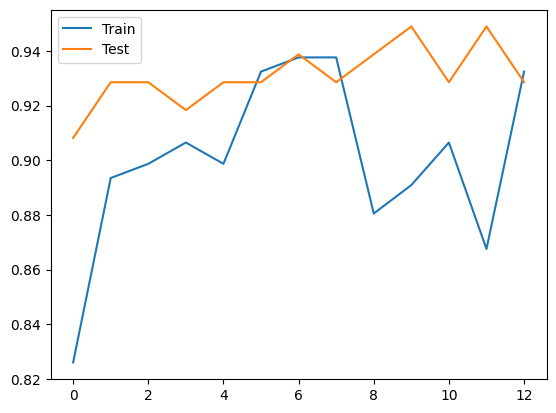

In [ ]:
# Train/test dataÏùò Ï†ïÌôïÎèÑÎ•º Í∑∏ÎûòÌîÑÎ°ú ÌôïÏù∏

plt.plot(train_acc_hist, label='Train')
plt.plot(val_acc_hist, label='Test')
plt.legend(loc=0)
plt.show()

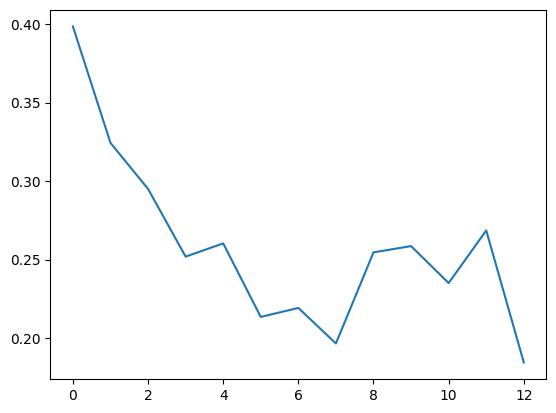

In [ ]:
# Training dataÏùò Ïò§Ï∞®Ïóê ÎåÄÌïú Í∑∏ÎûòÌîÑ ÌôïÏù∏

plt.plot(train_loss_hist)
plt.show()

In [ ]:
# ÏòàÏ∏° Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•ÏùÑ ÏúÑÌïú Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò

def im_convert(tensor):
    image = tensor.clone().detach().numpy() # Í∏∞Ï°¥ ÌÖêÏÑúÎ•º Î≥µÏÇ¨Ìïú ÏÉàÎ°úÏö¥ ÌÖêÏÑú ÏÉùÏÑ± but Í∏∞Ïö∏Í∏∞Ïóê ÏòÅÌñ• X
    image = image.transpose(1,2,0)
    image = image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image = image.clip(0,1) # ÏûÖÎ†• Í∞íÏù¥ Ï£ºÏñ¥ÏßÑ Î≤îÏúÑÎ•º Î≤óÏñ¥ÎÇ† Îïå ÏûÖÎ†•Í∞íÏùÑ ÌäπÏ†ï Î≤îÏúÑÎ°ú Ï†úÌïúÏãúÌÇ§Í∏∞ ÏúÑÌï¥ ÏÇ¨Ïö©
    return image

| .  | Î©îÎ™®Î¶¨ | .  |
|----|--------|----|
|`tensor.clone()`|ÏÉàÎ°≠Í≤å Ìï†Îãπ|Í≥ÑÏÇ∞ Í∑∏ÎûòÌîÑÏóê Í≥ÑÏÜç ÏÉÅÏ£º|
|`tensor.detach()`|Î©îÎ™®Î¶¨ Í≥µÏú†|Í≥ÑÏÇ∞ Í∑∏ÎûòÌîÑÏóê ÏÉÅÏ£º X|
|`tensor.clone().detach()`|ÏÉàÎ°≠Í≤å Ìï†Îãπ|Í≥ÑÏÇ∞ Í∑∏ÎûòÌîÑÏóê ÏÉÅÏ£º X|


In [ ]:
exam = np.array([-1.8, -1.2, -0.7, -0.4, 0.0, 0.3, 0.6, 1.9])
print(np.clip(exam, -0.5, 0.5))

[-0.5 -0.5 -0.5 -0.4  0.   0.3  0.5  0.5]


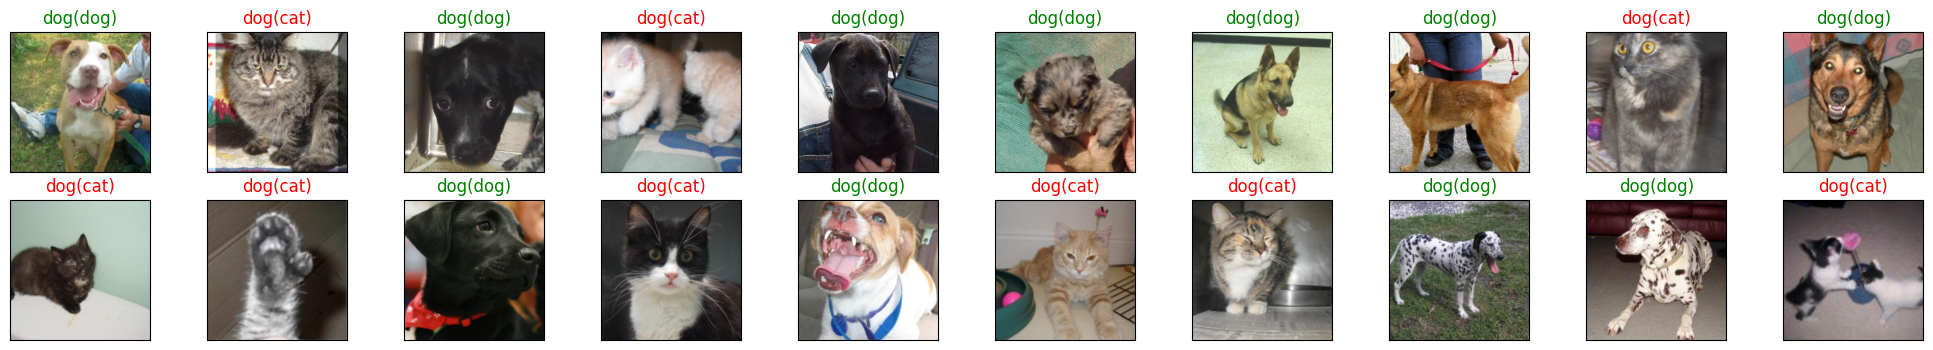

<Figure size 640x480 with 0 Axes>

In [ ]:
# Í∞úÏôÄ Í≥†ÏñëÏù¥ ÏòàÏ∏° Í≤∞Í≥º Ï∂úÎ†•

classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = model(images)
_, preds = torch.max(output,1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx])) # Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

# ÏÑ§Î™Ö Í∞ÄÎä•Ìïú CNN

### 5.4.1 ÌäπÏÑ± Îßµ ÏãúÍ∞ÅÌôî

**PIL** (Python Image Library)
- Ïù¥ÎØ∏ÏßÄ Î∂ÑÏÑù Î∞è Ï≤òÎ¶¨Î•º ÏâΩÍ≤å Ìï† Ïàò ÏûàÎèÑÎ°ù ÎèÑÏôÄÏ£ºÎäî ÎùºÏù¥Î∏åÎü¨Î¶¨
- Îã§ÏñëÌïú Ïù¥ÎØ∏ÏßÄ ÌååÏùº ÌòïÏãùÏùÑ ÏßÄÏõêÌï®
- Í∞ïÎ†•Ìïú Ïù¥ÎØ∏ÏßÄ Ï≤òÎ¶¨ÏôÄ Í∑∏ÎûòÌîΩ Í∏∞Îä•ÏùÑ Ï†úÍ≥µÌïòÎäî Ïù¥ÎØ∏ÏßÄ ÌîÑÎ°úÏÑ∏Ïã± ÎùºÏù¥Î∏åÎü¨Î¶¨

In [1]:
# ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ Ìò∏Ï∂ú

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# ÏÑ§Î™Ö Í∞ÄÎä•Ìïú ÎÑ§Ìä∏ÏõåÌÅ¨ ÏÉùÏÑ±

class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)
        # Î°úÍ∑∏ ÏÜåÌîÑÌä∏Îß•Ïä§ - vanishing gradient problem Ìï¥Í≤∞ ÏúÑÌï¥ Î°úÍ∑∏ Ï∑®Ìï®

In [3]:
# Î™®Îç∏ Í∞ùÏ≤¥Ìôî

model=XAI()
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [4]:
# ÌäπÏÑ± ÎßµÏùÑ ÌôïÏù∏ÌïòÍ∏∞ ÏúÑÌïú ÌÅ¥ÎûòÏä§ Ï†ïÏùò

class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # output = output
        # self.features = output.to(device).detach().numpy()
        self.features = output.detach().numpy()
    def remove(self):
        self.hook.remove()

`hook` : Í≥ÑÏÇ∞ Í≤∞Í≥ºÏóê Îî∞Îùº Í∞íÏù¥ Îã¨ÎùºÏßà Ïàò ÏûàÎäî Ï§ëÍ∞Ñ Î≥ÄÏàòÏùò Í∏∞Ïö∏Í∏∞ Í∞íÏùÑ Ïïå Ïàò ÏûàÏùå

```
import torch

x = torch.Tensor([0,1,2,3]).requires_grad()
y = torch.Tensor([4,5,6,7]).requires_grad()
w = torch.Tensor([1,2,3,4]).requires_grad()

z = x + y
o = w.matmul(z)
o.backward()

print(x.grad, y.grad, z.grad, w.grad, o,grad)
```
‚û°Ô∏è `tensor([2., 3., 4., 5.]) tensor([2., 3., 4., 5.]) None tensor([4., 6., 8., 10.,]) None`

oÏôÄ zÎäî Ï§ëÍ∞Ñ Î≥ÄÏàò! ÌååÏù¥ÌÜ†ÏπòÎäî Ïù¥Îü¨Ìïú Î≥ÄÏàòÏóê ÎåÄÌï¥ÏÑúÎäî Í∏∞Ïö∏Í∏∞ Í∞íÏùÑ Ï†ÄÏû•ÌïòÏßÄ ÏïäÏùå

BUT

`z.register_hook(hook_fn)` ÏÇ¨Ïö©ÌïòÎ©¥ Í∏∞Ïö∏Í∏∞ Í∞í Ïïå Ïàò ÏûàÏùå

torch.Size([3, 100, 100])


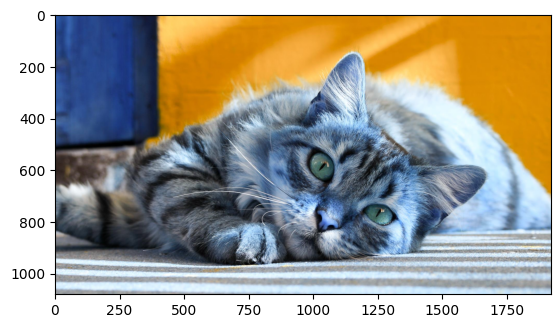

In [7]:
# Ïù¥ÎØ∏ÏßÄ Ìò∏Ï∂ú

img=cv2.imread("/content/drive/MyDrive/Colab Notebooks/Euron/cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR) # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Î≥ÄÍ≤Ω ~> Î≥¥Í∞ÑÎ≤ïÏúºÎ°ú ÌîΩÏÖÄ Ï∂îÏ†ï
img = ToTensor()(img) # (Ï±ÑÎÑê, ÎÜíÏù¥, ÎÑàÎπÑ)

print(img.shape)

torch.Size([1, 3, 100, 100])


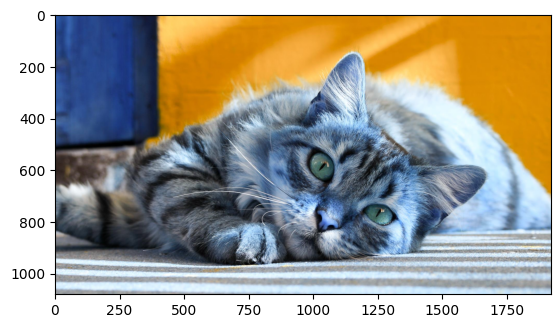

In [9]:
img=cv2.imread("/content/drive/MyDrive/Colab Notebooks/Euron/cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR) # Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Î≥ÄÍ≤Ω ~> Î≥¥Í∞ÑÎ≤ïÏúºÎ°ú ÌîΩÏÖÄ Ï∂îÏ†ï
img = ToTensor()(img).unsqueeze(0) # unsqueeze(0) : 0Î≤àÏß∏ Ï∞®ÏõêÏóê 1Ïù∏ Ï∞®Ïõê ÏÉùÏÑ± -> (Î∞∞Ïπò ÌÅ¨Í∏∞, Ï±ÑÎÑê, ÎÜíÏù¥, ÎÑàÎπÑ) => Ï∞®Ïõê ÎßûÏ∂îÎäî Ï†ÑÏ≤òÎ¶¨

print(img.shape)

In [10]:
# (0) : Conv2d ÌäπÏÑ± Îßµ ÌôïÏù∏

result = LayerActivations(model.features, 0)
model(img)
activations = result.features

<ipython-input-2-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


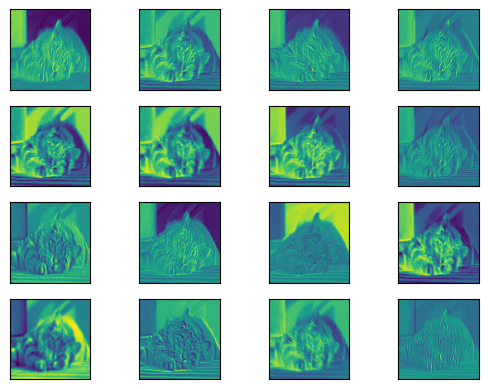

<Figure size 1200x800 with 0 Axes>

In [11]:
# ÌäπÏÑ± Îßµ ÌôïÏù∏

fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [12]:
result = LayerActivations(model.features, 20) # 20Î≤àÏß∏ Conv2d ÌäπÏÑ± Îßµ ÌôïÏù∏

model(img)
activations = result.features

<ipython-input-2-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


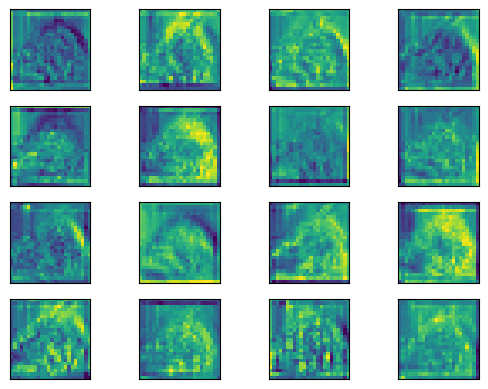

<Figure size 1200x800 with 0 Axes>

In [13]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [14]:
result = LayerActivations(model.features, 40) # 40Î≤àÏß∏ Conv2d ÌäπÏÑ± Îßµ ÌôïÏù∏

model(img)
activations = result.features

<ipython-input-2-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


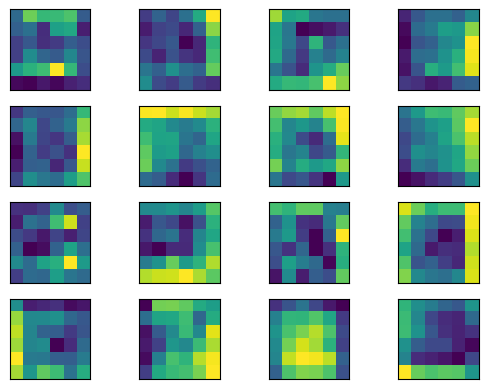

<Figure size 1200x800 with 0 Axes>

In [15]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()